# ONNX visualization

[ONNX](https://onnx.ai/) is a serialization format for machine learned model. It is a list of mathematical functions used to describe every prediction function for standard and deep machine learning. Module [onnx](https://github.com/onnx/onnx) offers some tools to [display ONNX graph](http://www.xavierdupre.fr/app/sklearn-onnx/helpsphinx/auto_examples/plot_pipeline.html). [Netron](https://github.com/lutzroeder/netron) is another approach. The following notebooks explore a ligher visualization.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Train a model

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Convert a model

In [3]:
import numpy
from skl2onnx import to_onnx
model_onnx = to_onnx(clr, X_train.astype(numpy.float32))

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


## Explore it with OnnxInference

In [4]:
from mlprodict.onnxrt import OnnxInference

sess = OnnxInference(model_onnx)
sess

OnnxInference(...)

In [5]:
print(sess)

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.0"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    output: "label"
    output: "probability_tensor"
    name: "LinearClassifier"
    op_type: "LinearClassifier"
    attribute {
      name: "classlabels_ints"
      ints: 0
      ints: 1
      ints: 2
      type: INTS
    }
    attribute {
      name: "coefficients"
      floats: 0.40225541591644287
      floats: 1.3442842960357666
      floats: -2.134634017944336
      floats: -0.9660071134567261
      floats: 0.09299517422914505
      floats: -1.139763355255127
      floats: 0.6132837533950806
      floats: -1.0851963758468628
      floats: -1.4666730165481567
      floats: -1.517818570137024
      floats: 2.278202533721924
      floats: 2.1202523708343506
      type: FLOATS
    }
    attribute {
      name: "intercepts"
      floats: 0.23659107089042664
      floats: 1.0773710012435913
      floats: -1.0754358768463135
      type: FLOA

## dot

In [6]:
dot = sess.to_dot()
print(dot)

digraph{
  nodesep=0.05;
  ranksep=0.25;
  orientation=portrait;

  X [shape=box color=red label="X\nfloat((1, 4))" fontsize=10];

  output_label [shape=box color=green label="output_label\nint64((1,))" fontsize=10];
  output_probability [shape=box color=green label="output_probability\n[{int64, {'kind': 'tensor', 'elem': 'float', 'shape': }}]" fontsize=10];


  label [shape=box label="label" fontsize=10];
  probability_tensor [shape=box label="probability_tensor" fontsize=10];
  LinearClassifier [shape=box style="filled,rounded" color=orange label="LinearClassifier\n(LinearClassifier)\nclasslabels_ints=[0 1 2]\ncoefficients=[ 0.40225542  1.34...\nintercepts=[ 0.23659107  1.0773...\nmulti_class=1\npost_transform=b'LOGISTIC'" fontsize=10];
  X -> LinearClassifier;
  LinearClassifier -> label;
  LinearClassifier -> probability_tensor;

  probabilities [shape=box label="probabilities" fontsize=10];
  Normalizer [shape=box style="filled,rounded" color=orange label="Normalizer\n(Normalizer)

In [7]:
from jyquickhelper import RenderJsDot
RenderJsDot(dot)

## magic commands

The module implements a magic command to easily display graphs.

In [8]:
%load_ext mlprodict

In [9]:
%onnxview model_onnx

## runtime

Let's compute the prediction using a Python runtime.

In [10]:
prob = sess.run({'X': X_test})['output_probability']
prob[:5]

[{0: 0.025367569347286414, 1: 0.6191580274929936, 2: 0.35547440315971995},
 {0: 0.023559059277615774, 1: 0.68626945791549, 2: 0.2901714828068941},
 {0: 0.81822195028684, 1: 0.18163192755963514, 2: 0.00014612215352491947},
 {0: 0.0005387867630864459, 1: 0.43029418260611735, 2: 0.5691670306307962},
 {0: 0.0010016230255242165, 1: 0.30479396539962084, 2: 0.694204411574855}]

In [11]:
import pandas
prob = pandas.DataFrame(prob).values
prob[:5]

array([[2.53675693e-02, 6.19158027e-01, 3.55474403e-01],
       [2.35590593e-02, 6.86269458e-01, 2.90171483e-01],
       [8.18221950e-01, 1.81631928e-01, 1.46122154e-04],
       [5.38786763e-04, 4.30294183e-01, 5.69167031e-01],
       [1.00162303e-03, 3.04793965e-01, 6.94204412e-01]])

Which we compare to the original model.

In [12]:
clr.predict_proba(X_test)[:5]

array([[2.53675706e-02, 6.19158139e-01, 3.55474290e-01],
       [2.35590603e-02, 6.86269596e-01, 2.90171344e-01],
       [8.18221952e-01, 1.81631926e-01, 1.46122086e-04],
       [5.38786689e-04, 4.30294215e-01, 5.69166998e-01],
       [1.00162296e-03, 3.04794011e-01, 6.94204366e-01]])

Some time measurement...

In [13]:
%timeit clr.predict_proba(X_test)

90.1 µs ± 9.55 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%timeit sess.run({'X': X_test})['output_probability']

195 µs ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


With one observation:

In [15]:
%timeit clr.predict_proba(X_test[:1])

110 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit sess.run({'X': X_test[:1]})['output_probability']

58.7 µs ± 7.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%matplotlib inline

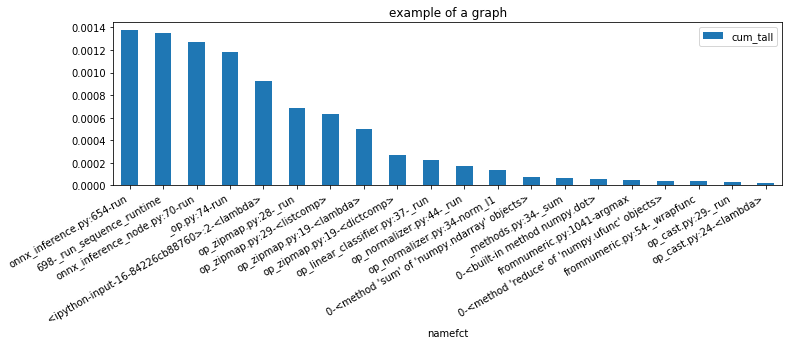

In [18]:
from pyquickhelper.pycode.profiling import profile
pr, df = profile(lambda: sess.run({'X': X_test})['output_probability'], as_df=True)
ax = df[['namefct', 'cum_tall']].head(n=20).set_index('namefct').plot(kind='bar', figsize=(12, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');